## **Table of Contents**



1.   Setup
2.   OpenAI Gym Environment

In [4]:
# Installing OpenAI Gym and Arcade Learning Environment (ALE)
# https://github.com/openai/gym
# https://github.com/mgbellemare/Arcade-Learning-Environment

!pip install gym gym[atari,accept-rom-license]==0.22.0

     |████████████████████████████████| 631 kB 4.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.6 MB 59.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.22.0-py3-none-any.whl size=708399 sha256=ea98943fe407f7934c942963ef798f1cace7e58f75423cfd0e984915fb50d0e7
  Stored in directory: /root/.cache/pip/wheels/7d/5e/87/7d50e0179edda70feff5bba05c381041e1c1fd80c6b06a4cc3
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=7d77f03c685794f64a5967856d33c15b780fe1849b0ccf79d0428a1a1788268a
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built gym AutoROM.accept-rom-license
  Attempting uninstall: gym
    

In [5]:
# Colab render visualization setup
# source: https://yashk2000.github.io/blog/rendering-openai-gym-envs-in-colab/

!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!pip install pygame

     |████████████████████████████████| 21.8 MB 1.4 MB/s 


In [6]:
# in order to complete the DQN import, need to pip install this
# for some reason the pip install is unique on colab, sourced from here: https://github.com/seungjaeryanlee/osim-rl-helper/issues/7

!pip install keras-rl2

     |████████████████████████████████| 52 kB 798 kB/s 
     |████████████████████████████████| 462 kB 5.8 MB/s 


In [7]:
# !pip freeze

In [8]:
# You cant import these after the model creation for some reason, the sequentialmemory import messes up the model. Not sure why.

from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

In [9]:
import gym
import ale_py

import matplotlib.pyplot as plt
%matplotlib inline 

%tensorflow_version 2.x
import tensorflow as tf

import os
import shutil

import numpy as np

import warnings
import random

In [10]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [11]:
# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

In [12]:
# Random Seed

# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
np.random.seed(random_seed)

In [13]:
# Check what version of TF we are using
print(tf.version.VERSION)

2.8.0


In [14]:
# Print the number of GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Test to see if GPU is found and connected
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('\nFound GPU at: {}'.format(device_name))
  print('\nCurrently using:')
  !nvidia-smi -L

Num GPUs Available:  1

Found GPU at: /device:GPU:0

Currently using:
GPU 0: Tesla T4 (UUID: GPU-c632a00e-0493-3733-81db-8d4d5c510249)


Google Colab does not have a built in way to display, so we will have to create our own. There is a couple different methods to do this, but I was using method 3 found here: https://yashk2000.github.io/blog/rendering-openai-gym-envs-in-colab/ 

# Visualization Setup

In [15]:
# create a dummy environment to store the video of the game 
# if we were to actually store the video we would have to remove the old video every time 
# import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((1280,960))
# we can make the display bigger here when we want to expand it

<Surface(1280x960x32 SW)>

In [16]:
# A quick test using the example from the source
from colabgymrender.recorder import Recorder

env = gym.make('CartPole-v0')
directory = './video'
env = Recorder(env, directory)

curr_state = env.reset()
done = False
while not done:
  action = env.action_space.sample()
  curr_state, _, done, info = env.step(action)

env.play()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1802240/45929032 bytes (3.9%)4808704/45929032 bytes (10.5%)7413760/45929032 bytes (16.1%)10362880/45929032 bytes (22.6%)12353536/45929032 bytes (26.9%)14712832/45929032 bytes (32.0%)16179200/45929032 bytes (35.2%)18882560/45929032 bytes (41.1%)20398080/45929032 bytes (44.4%)22839296/45929032 bytes (49.7%)25370624/45929032 bytes (55.2%)27549696/45929032 bytes (60.0%)

# Ms. Pacman Random Model

Now let's try it with Ms. Pacman and the random model

In [17]:
# Just messing around with gym - Josh

env = gym.make('ALE/MsPacman-v5')
height, width, channels = env.observation_space.shape
actions = env.action_space.n
directory = './video'
env = Recorder(env, directory)

In [18]:
print(height, width, channels)

210 160 3


In [19]:
# Our agent's possible actions
env.unwrapped.get_action_meanings()

['NOOP',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT']

In [20]:
# testing the random model 
# code from here: https://www.youtube.com/watch?v=hCeJeq8U0lo
# we remove env.render() and instead include env.play()
# episodes is the number of games
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = random.choice([0,1,2,3,4,5,6,7,8])
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
    env.play()
env.close()
# still probably better than I would do

Episode:1 Score:160.0


In [21]:
#### ALTERNATIVE RENDERING
#from IPython import display

In [22]:
#render = lambda : plt.imshow(env.render(mode='rgb_array'))

In [23]:
#### redifining env
#env = gym.make('ALE/MsPacman-v5')
#height, width, channels = env.observation_space.shape
#actions = env.action_space.n

Episode:1 Score:230.0


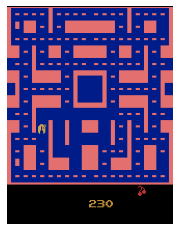

In [24]:
#### This works well on jupyter notebooks, and awfully here
#episodes = 1
#for episode in range(1, episodes+1):
    #state = env.reset()
    #done = False
    #score = 0 
    #img = plt.imshow(env.render(mode='rgb_array')) 
    #while not done:
        #img.set_data(env.render(mode='rgb_array'))
        #plt.axis('off')
        #display.display(plt.gcf())
        #display.clear_output(wait=True)
        #action = random.choice([0,1,2,3,4,5,6,7,8])
        #n_state, reward, done, info = env.step(action)
        #score+=reward
    #print('Episode:{} Score:{}'.format(episode, score))
    
#env.close()

# 2. Create a Deep Learning Model with Keras

In [ ]:
# Again taken from: https://www.youtube.com/watch?v=hCeJeq8U0lo
# Here we build the CNN. We can alter all of the model creation later in order to make the model as successful as possible
from keras.models import Sequential
from keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
# if you make a mistake, remember to delete the model
# del model

In [ ]:
model = build_model(height, width, channels, actions)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 51, 39, 32)     6176      
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 24, 18, 64)     32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 22, 16, 64)     36928     
                                                                 
 flatten (Flatten)           (None, 67584)             0         
                                                                 
 dense (Dense)               (None, 512)               34603520  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 9)                 2

# 3. Build Agent with Keras-RL

In [ ]:
# here I needed to change enable_dueling_network to False, otherwise I was getting a recurssion error
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=1000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=False, dueling_type='avg',
                   nb_actions=actions, nb_steps_warmup=1000
                  )
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-4))

In [ ]:
# this will take a very long time to run unless you lower the steps
# right now we are running at 2000 steps, with an 1000 step warmup in the agent, so it is barely fitting at all
# in the video he mentioned that the creators of the algorithm recommended to run this for 10 million steps, so that may be what we need the GPU EC2 instance for
# if you dont want to wait, just press the stop button on the cell and it will stop the model training where it is with no error
dqn.fit(env, nb_steps=2000, visualize=False, verbose=2)
#### I will see if I can figure out how to train the fitting process, as this is the funny part where our model looks stupid

Training for 2000 steps ...
  514/2000: episode: 1, duration: 17.200s, episode steps: 514, steps per second:  30, episode reward: 350.000, mean reward:  0.681 [ 0.000, 10.000], mean action: 3.877 [0.000, 8.000],  loss: --, mean_q: --, mean_eps: --
 1088/2000: episode: 2, duration: 101.807s, episode steps: 574, steps per second:   6, episode reward: 290.000, mean reward:  0.505 [ 0.000, 10.000], mean action: 4.061 [0.000, 8.000],  loss: 107.815611, mean_q: 61.015555, mean_eps: 0.906040
 1542/2000: episode: 3, duration: 454.633s, episode steps: 454, steps per second:   1, episode reward: 140.000, mean reward:  0.308 [ 0.000, 10.000], mean action: 3.963 [0.000, 8.000],  loss: 4.824206, mean_q: 53.732439, mean_eps: 0.881695
done, took 1030.234 seconds


In [ ]:
# this is not gonna be much better than the random model cause we are hardly training, just wanted to get it all working first
# I also created a loop so it will play the video of each test after each try, since we cannot use Visualize = True
# the model is already fit here, so each result does not build off the last one, these tests are their own independent trials (to my understanding)
i = 0
avg_calc = []
while i < 3:
  scores = dqn.test(env, nb_episodes=1, visualize=False)
  avg_calc.append(scores.history['episode_reward'][0])
  env.play()
  i += 1
print('Average Score:', sum(avg_calc)/len(avg_calc))

Testing for 1 episodes ...
Episode 1: reward: 430.000, steps: 520


Testing for 1 episodes ...
Episode 1: reward: 390.000, steps: 438


Testing for 1 episodes ...
Episode 1: reward: 510.000, steps: 602


Average Score: 443.3333333333333


In [ ]:
# to save our model:
# dqn.save_weights('insertfilepathhere/dqn_weights.h5f')
# to load a model:
# del model, dqn
# dqn.load_weights('insertfilepathhere/dqn_weights.h5f')